## this python script create the correlation between trigger capablity and physical channels

In [50]:
from gensim.models import Word2Vec, KeyedVectors 
from scipy.spatial.distance import cdist # for the Manhattan distance
import json   # for read the JSON file
import stanza # Official Stanford NLP Python Library for Many Human Languages
import re     # for preprocessing the descriptions (necessary for using the word2vec)
import numpy as np

In [51]:
file = open("trigger-action_FINAL.JSON","r") # read all the capability extrapolated from the apps
trigger_action = json.load(file)
print("tot app analysed:",len(trigger_action.keys()))

tot app analysed: 84


In [52]:
file = open("app-description.JSON","r") # need the desription of the analysed apps
app_description = json.load(file)

In [53]:
file = open("cluster_pysical_channels_FINAL.JSON","r") 
dict_physical_channels = json.load(file)

In [54]:
stanza.download('en')       # This downloads the English models for the neural pipeline
nlp = stanza.Pipeline('en') # This sets up a default neural pipeline in English
model = KeyedVectors.load_word2vec_format('/home/volta/Documenti/CCS18_CS/word2vec/GoogleNews-vectors-negative300.bin', binary=True, limit=100000) # load word2vec pre-trained

2021-09-23 10:15:47 INFO: Downloading default packages for language: en (English)...
2021-09-23 10:15:48 INFO: File exists: /home/volta/stanza_resources/en/default.zip.
2021-09-23 10:15:53 INFO: Finished downloading models and saved to /home/volta/stanza_resources.
2021-09-23 10:15:53 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| sentiment | sstplus   |
| ner       | ontonotes |

2021-09-23 10:15:53 INFO: Use device: cpu
2021-09-23 10:15:53 INFO: Loading: tokenize
2021-09-23 10:15:53 INFO: Loading: pos
2021-09-23 10:15:53 INFO: Loading: lemma
2021-09-23 10:15:53 INFO: Loading: depparse
2021-09-23 10:15:54 INFO: Loading: sentiment
2021-09-23 10:15:54 INFO: Loading: ner
2021-09-23 10:15:55 INFO: Done loading processors!


In [55]:
POS_accepted=["NN"]  # part of speech tags accepted ---> deleted: "NNS", "NNP", "NNPS"
app_to_physical_channel = {}
for app in trigger_action.keys(): # analyse every app
    keywords = [] # keywords found of an app description -> dictionary as "keyword": 300-vector description space
    #print("analysing app description", app)
    #app="beacon-control"
    des_analysed = nlp(app_description[app])     # apply Stanford NLP to description
    for sent in des_analysed.sentences:
        for word in sent.words:                               # check each word of the description
            if word.xpos in POS_accepted:
                keyword_found = word.text.lower()             # filter: to all lowercase words
                if not keyword_found in keywords:      # if not already saved, store that word of the same desc
                    #print(f"found word:{word.text}   \txpos: {word.xpos}\n")
                    keywords.append(keyword_found)            # add to the list of keywords

    # after finish to check the app description words
    clean_keywords = []
    for i in range(len(keywords)):                            # for every keyword exstracted
        try:
            model[keywords[i]]                                # check Word2Vec
            clean_keywords.append(keywords[i])
        except KeyError as err:
            print("handling Error: ", err)                    # some words can not be processed by Word2Vec

    print(clean_keywords)        
    similarity_matrix = {}

    if len(clean_keywords) == 0: # case there aren't any NN o NNS keyword inside that app description (strange)
        print(f"-->app [{app}] non presenta nessun NN o NNS")

    else:
        if len(clean_keywords) == 1: # case there are only 1 NN o NNS keyword inside that app description
            for key in dict_physical_channels.keys(): # check for every physical channel
                similarity_temp = 0
                for channel_NN in range(len(dict_physical_channels[key])):
                    similarity_temp += model.similarity(clean_keywords[0],dict_physical_channels[key][channel_NN])
                similarity_matrix[key] = (similarity_temp/len(dict_physical_channels[key]))*100

        else: # case there are more than 1 NN o NNS keyword inside that app description
            for key in dict_physical_channels.keys(): # check for every physical channel
                similarity_partial = 0
                for keyword in clean_keywords:
                    similarity_temp = 0
                    for channel_NN in dict_physical_channels[key]:
                        #print(keyword,channel_NN,"\t", model.similarity(keyword,channel_NN))
                        similarity_temp += model.similarity(keyword,channel_NN)

                    similarity_temp = similarity_temp/len(dict_physical_channels[key])
                    #print(keyword, similarity_temp)
                    similarity_partial += similarity_temp
                    #print(keyword, similarity_partial)
                #print("this keyword for ",key,"has got a level", similarity_partial/len(clean_keywords))
                similarity_matrix[key] = (similarity_partial/len(clean_keywords))*100
        channel_association = ""
        max_value = 0
        for key in similarity_matrix.keys():
            if (similarity_matrix[key] > max_value):
                max_value = similarity_matrix[key]
                channel_association = key


        #print(similarity_matrix)
        print("most similar:", channel_association, max_value)
        app_to_physical_channel[app] = channel_association
# y_correlation = np.argmin(distance_matrix) % 7            # remember from 0 to 6 ! [7 physical channels]
# physical_channel_tag = switch_physical_channel(y_correlation)
# #print(physical_channel_tag)
# discharge = ["capability.app", "time", "capability.powerMeter", "capability.accelerationSensor"]
# for capability in trigger_action[app].keys():  
#     if not capability in discharge: 
#         print(f"[{app}] use P_Ch:{physical_channel_tag}\tcap:{capability}")
#         physical_ch_capabilities[physical_channel_tag].append(capability)
#     else:
#         print(f"[{app}]--- time, app or powerMeter")

['home', 'phrase', 'door', 'region']
most similar: leakage 10.54866173459838
[]
-->app [big-turn-off] non presenta nessun NN o NNS
[]
-->app [big-turn-on] non presenta nessun NN o NNS
['set', 'presence', 'mode', 'change', 'everyone', 'conjunction', 'turn', 'thermostat', 'security']
most similar: humidity 11.983659036882779
['sensor', 'space']
most similar: motion 33.11494973798593
['motion']
most similar: motion 50.601282715797424
['control']
most similar: motion 13.009269287188848
['power', 'time']
most similar: location 12.271495763626364
[]
-->app [cameras-on-when-im-away] non presenta nessun NN o NNS
['carpooling', 'person', 'notification']
most similar: leakage 18.99312634745406
['valve', 'moisture', 'sms', 'notification']
most similar: temperature 20.499257955598296
['outlet', 'user', 'period', 'time']
most similar: location 13.965508308158153
['period', 'motion']
most similar: motion 25.13533596259852
['number', 'switch', 'row']
most similar: illumination 8.88240902656407
['mois

In [56]:
app_to_physical_channel

{'beacon-control': 'leakage',
 'bon-voyage': 'humidity',
 'brighten-dark-places': 'motion',
 'brighten-my-path': 'motion',
 'button-controller': 'motion',
 'camera-power-scheduler': 'location',
 'carpool-notifier': 'leakage',
 'close-the-valve': 'temperature',
 'curling-iron': 'location',
 'darken-behind-me': 'motion',
 'double-tap': 'illumination',
 'dry-the-wetspot': 'temperature',
 'elder-care-daily-routine': 'location',
 'elder-care-slip-fall': 'motion',
 'energy-alerts': 'humidity',
 'energy-saver': 'humidity',
 'feed-my-pet': 'location',
 'flood-alert': 'leakage',
 'forgiving-security': 'location',
 'garage-door-monitor': 'leakage',
 'garage-door-opener': 'smoke',
 'good-night': 'motion',
 'greetings-earthling': 'location',
 'habit-helper': 'leakage',
 'has-barkley-been-fed': 'location',
 'hub-ip-notifier': 'location',
 'humidity-alert': 'humidity',
 'it-moved': 'leakage',
 'its-too-cold': 'humidity',
 'its-too-hot': 'humidity',
 'keep-me-cozy': 'humidity',
 'keep-me-cozy-ii': 't

In [79]:
dict_channels_capability={"temperature":[], "humidity":[], "illumination":[], "location":[],
                          "motion":[], "smoke":[], "leakage":[]}
dict_actions_capability={"temperature":[], "humidity":[], "illumination":[], "location":[],
                          "motion":[], "smoke":[], "leakage":[]}

capability_not_accepted = ["capability.app","time", "sendAction", "locationMode", "hub" ]
for app in app_to_physical_channel.keys():
    list_of_capabilities = trigger_action[app].keys()
    for capability in list_of_capabilities:
        if not capability in capability_not_accepted:
            if not capability in dict_channels_capability[app_to_physical_channel[app]]:
                dict_channels_capability[app_to_physical_channel[app]].append(capability)

In [80]:
dict_channels_capability

{'temperature': ['capability.waterSensor',
  'capability.location',
  'capability.temperatureMeasurement',
  'capability.thermostat',
  'capability.relativeHumidityMeasurement',
  'capability.motionSensor',
  'capability.contactSensor'],
 'humidity': ['capability.presenceSensor',
  'capability.powerMeter',
  'capability.relativeHumidityMeasurement',
  'capability.temperatureMeasurement',
  'capability.thermostat',
  'capability.location',
  'capability.switch',
  'capability.contactSensor',
  'device.jawboneUser',
  'capability.motionSensor',
  'capability.alarm'],
 'illumination': ['capability.switch',
  'capability.accelerationSensor',
  'capability.button',
  'capability.location',
  'capability.contactSensor',
  'capability.presenceSensor'],
 'location': ['capability.motionSensor',
  'capability.presenceSensor',
  'capability.contactSensor',
  'capability.location'],
 'motion': ['capability.contactSensor',
  'capability.motionSensor',
  'capability.button',
  'capability.switch',
 

In [86]:
dict_actions_related={"temperature":[], "humidity":[], "illumination":[], "location":[],
                          "motion":[], "smoke":[], "leakage":[]}
dict_trigger_related={"temperature":[], "humidity":[], "illumination":[], "location":[],
                          "motion":[], "smoke":[], "leakage":[]}

for app in trigger_action.keys(): # for every app where I can extrapolate info
    if app in app_to_physical_channel.keys(): # some app description couldn't have some NN 
        physical_channel_correlated = app_to_physical_channel[app] # save the physical trigger channel of that app
        for trigger_cap in trigger_action[app].keys(): # for every trigger channel of that app
            if not trigger_cap in capability_not_accepted: # if the trigger capability is accepted
                dict_trigger_related[physical_channel_correlated].append(trigger_cap) # save it 
                
for app in trigger_action.keys(): # for every app where I can extrapolate info
    for trigger_cap in trigger_action[app].keys(): # for every app trigger trigger capability
        if not trigger_cap in capability_not_accepted: # if trigger capability is accepted
            for actions in trigger_action[app][trigger_cap]: # for every action correlated to that trigger capability
                action_capability = actions[0] # save the action capability
                if not action_capability in capability_not_accepted: # is the action capability is accepted
                    for physical_channel in dict_channels_capability.keys(): # for every physical channel
                        if action_capability in dict_channels_capability[physical_channel]: # find if there is that action capability
                            dict_actions_related[physical_channel].append(action_capability) # if there is save the action capability 
dict_actions_related

{'temperature': ['capability.thermostat',
  'capability.thermostat',
  'capability.thermostat',
  'capability.thermostat',
  'capability.thermostat',
  'capability.thermostat',
  'capability.thermostat',
  'capability.thermostat',
  'capability.thermostat',
  'capability.thermostat',
  'capability.thermostat',
  'capability.thermostat',
  'capability.thermostat',
  'capability.thermostat',
  'capability.thermostat',
  'capability.thermostat',
  'capability.thermostat',
  'capability.thermostat'],
 'humidity': ['capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.switch',
  'capability.alarm',
  'c

In [87]:
action_related = []
for key in dict_actions_related.keys():
    action_related.append(len(dict_actions_related[key]))
action_related = np.array(action_related)
action_related

array([18, 88, 63,  0, 63, 63, 63])

In [90]:
trigger_related = []
for key in dict_trigger_related.keys():
    trigger_related.append(len(dict_trigger_related[key]))
trigger_related = np.array(trigger_related)
trigger_related

array([11, 16,  7, 11, 24,  2, 20])

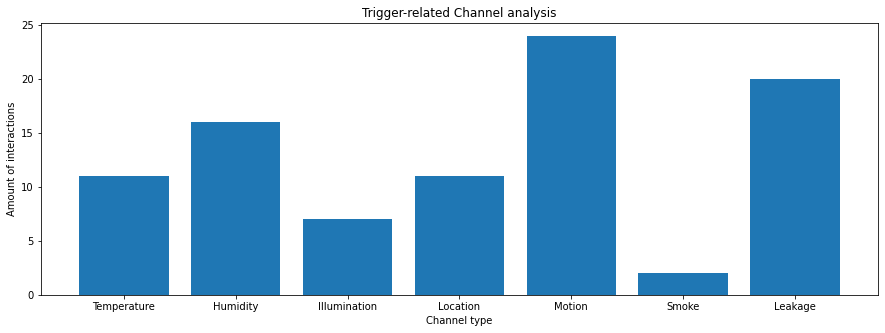

In [91]:
import matplotlib.pyplot as plt

x = ["Temperature","Humidity", "Illumination", "Location", "Motion", "Smoke", "Leakage" ]
x_pos = np.arange(len(x))
plt.figure(figsize=[15, 5])
plt.bar(x_pos, trigger_related, align='center')
plt.xticks(x_pos, x)
plt.ylabel('Amount of interactions')
plt.xlabel('Channel type')
plt.title('Trigger-related Channel analysis')
plt.show()

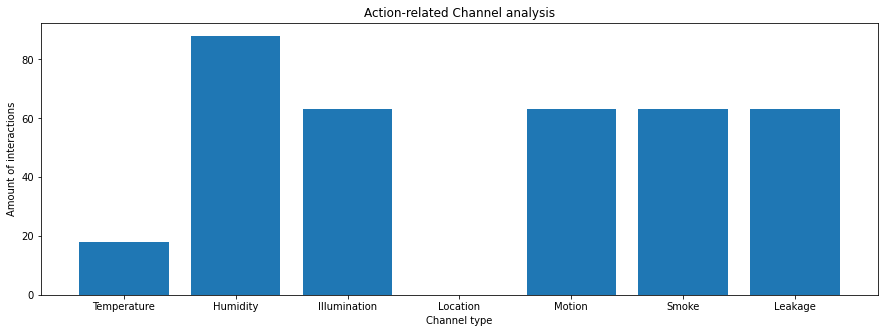

In [92]:
x_pos = np.arange(len(x))
plt.figure(figsize=[15, 5])
plt.bar(x_pos, action_related, align='center')
plt.xticks(x_pos, x)
plt.ylabel('Amount of interactions')
plt.xlabel('Channel type')
plt.title('Action-related Channel analysis')
plt.show()